In [60]:
!pip install pyIGRF
import numpy as np
from numpy import linalg as LA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pyIGRF
import math

In [61]:
def TIBquat(q0123_temp):
    q_0 = q0123_temp[0]
    q_1 = q0123_temp[1]
    q_2 = q0123_temp[2]
    q_3 = q0123_temp[3]

    q0s = q_0 ** 2
    q1s = q_1 ** 2
    q2s = q_2 ** 2
    q3s = q_3 ** 2

    R = np.array([[(q0s + q1s - q2s - q3s),2 * (q_1 * q_2 - q_0 * q_3), 2 * (q_0 * q_2 + q_1 * q_3)],
    [2 * (q_1 * q_2 + q_0 * q_3), (q0s - q1s + q2s - q3s), 2 * (q_2 * q_3 - q_0 * q_1)],
    [2 * (q_1 * q_3 - q_0 * q_2), 2 * (q_0 * q_1 + q_2 * q_3), (q0s - q1s - q2s + q3s)]])
    return R

In [62]:
def TIB(phi,theta,psi):
    ct = np.cos(theta)
    st = np.sin(theta)
    sp = np.sin(phi)
    cp = np.cos(phi)
    ss = np.sin(psi)
    cs = np.cos(psi)

    out = np.array([[ct*cs,sp*st*cs-cp*ss,cp*st*cs+sp*ss],
        [ct*ss,sp*st*ss+cp*cs,cp*st*ss-sp*cs],
        [-st,sp*ct,cp*ct]])
    return out

In [63]:
def EulerAngles2Quaternions(phi_theta_psi):
    phi = phi_theta_psi[0]
    theta = phi_theta_psi[1]
    psi = phi_theta_psi[2]

    q_0 = np.cos(phi/2) * np.cos(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.sin(theta/2) * np.sin(psi/2)
    q_1 = np.sin(phi/2) * np.cos(theta/2) * np.cos(psi/2) - np.cos(phi/2) * np.sin(theta/2) * np.sin(psi/2)
    q_2 = np.cos(phi/2) * np.sin(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.cos(theta/2) * np.sin(psi/2)
    q_3 = np.cos(phi/2) * np.cos(theta/2) * np.sin(psi/2) - np.sin(phi/2) * np.sin(theta/2) * np.cos(psi/2)

    quaternion = np.array([q_0, q_1, q_2, q_3])
    return quaternion

In [64]:
def Quaternions2EulerAngles(q0123_temp):
    q_0 = q0123_temp[:, 0]
    q_1 = q0123_temp[:, 1]
    q_2 = q0123_temp[:, 2]
    q_3 = q0123_temp[:, 3]
    euler = np.zeros((q0123_temp.shape[0], 3))
    euler[:,0] = np.arctan2(2 * (q_0 * q_1 + q_2 * q_3), 1 - 2 * (q_1**2 + q_2**2))  # phi
    euler[:,1] = np.arcsin(2 * (q_0 * q_2 - q_3 * q_1))  # theta
    euler[:,2] = np.arctan2(2 * (q_0 * q_3 + q_1 * q_2), 1 - 2 * (q_2**2 + q_3**2))  # psi
    euler = np.real(euler)
    return euler

In [65]:
def Quaternions2EulerAngles_single(q0123_temp):
    q_0 = q0123_temp[0]
    q_1 = q0123_temp[1]
    q_2 = q0123_temp[2]
    q_3 = q0123_temp[3]
    euler = np.zeros(3)
    euler[0] = np.arctan2(2 * (q_0 * q_1 + q_2 * q_3), 1 - 2 * (q_1**2 + q_2**2))  # phi
    euler[1] = np.arcsin(2 * (q_0 * q_2 - q_3 * q_1))  # theta
    euler[2] = np.arctan2(2 * (q_0 * q_3 + q_1 * q_2), 1 - 2 * (q_2**2 + q_3**2))  # psi
    euler = np.real(euler)
    return euler

In [66]:
k = 67200
n_turns = 84  # no. of turns
Area = 0.02  # Area in meters ^ 2
k_nA = 67200/(84*0.02)
nA = 84*0.02
maxCurrent = 120  # mAmps
R = 6.371e6 #meters
M = 5.972e24 #kg
G = 6.67e-11
mu = G*M
#inertia and mass
ms = 1.6 #kilograms
lx = 10/100 #meters
ly = 10/100 #meters
lz = 15/100 #meters
l = np.array((lx,ly,lz))
CD = 1.0
Is = np.array([[4.5e-3,-3.2e-4,0],[-3.2e-4,5.1e-3,0],[0,0,3.7e-3]])
invI = LA.inv(Is)

In [67]:
altitude = 575*1000 #meters
x0 = R + altitude
y0 = 0
z0 = 0
xdot0 = 0
inclination = 51.6*np.pi/180
semi_major = LA.norm([x0,y0,z0])
vcircular = np.sqrt(mu/semi_major)
ydot0 = vcircular*np.cos(inclination)
zdot0 = vcircular*np.sin(inclination)
period = 2*np.pi/(np.sqrt(mu))*semi_major**(3/2)

In [68]:
#Intitial Conditions for Attitude and Angular Velocity
phi0 = 0
theta0 = 0
psi0 = 0
ptp0 = np.array([phi0,theta0,psi0])
q0123_0 = EulerAngles2Quaternions(ptp0)
p0 = 0.5
q0 = -0.02
r0 = 0.03

In [69]:
initial_state_f = np.array([x0,y0,z0,xdot0,ydot0,zdot0,q0123_0[0],q0123_0[1],q0123_0[2],q0123_0[3],p0,q0,r0])
print('init_state',initial_state_f.shape)
Bx_list = []
By_list = []
Bz_list = []
BBx_list = []
BBy_list = []
BBz_list = []
BB_meas_x_list = []
BB_meas_y_list = []
BB_meas_z_list = []
p_meas_list = []
q_meas_list = []
r_meas_list = []
nextSensorUpdate = 1
lastSensorUpdate = 0.0
fsensor=1

init_state (13,)


In [70]:
def bcross_control(BfieldM,pqrM):
    norm_b = np.linalg.norm(BfieldM)
    b = BfieldM/norm_b # normalize magnetic field vector
    mu = (1/ norm_b)* np.cross(pqrM, b)
    for i in range(3):
        if(mu[i] > 0.2):
            mu[i] = 0.2
        elif(mu[i] < -0.2):
            mu[i] = -0.2
    return mu

In [71]:
def bdot_control(BfieldM):
    mu = -1*(BfieldM/LA.norm(BfieldM))
    for i in range(3):
        if(mu[i] > 0.2):
            mu[i] = 0.2
        elif(mu[i] < -0.2):
            mu[i] = -0.2
    #print('mu',mu)
    return mu

In [72]:
def get_B_dot(B1,B2,dt):
    B_dot = (B2-B1)/dt
    return B_dot

In [73]:
def Satellite(t, state):
    global Bx, By, Bz, BB_f, InvI, lastSensorUpdate, BfieldMeasured, pqrMeasured, ptpMeasured, BB_f_prev
    vel = state[3:6]

    #rotational kinematics
    q0123 = state[6:10]
    p = state[10]
    q = state[11]
    r = state[12]
    pqr = state[10:13]
    ptp = Quaternions2EulerAngles_single(q0123)
    PQRMAT = np.array([[0, - p, - q, - r], [p, 0, r, -q], [q, -r, 0, p], [r, q, -p, 0]])
    q0123dot = 0.5*np.matmul(PQRMAT, q0123)
    xyz = state[0:3]
    x = state[0]
    y = state[1]
    z = state[2]
    rho = LA.norm(xyz)
    rhat = xyz/rho
    phiE = 0
    thetaE = np.arccos(z / rho)
    psiE = math.atan2(y, x)
    latitude = 90 - thetaE * 180 / np.pi
    longitude = psiE * 180 / np.pi
    rhokm = rho / 1000
    _, _, _, BN, BE, BD, _ = pyIGRF.igrf_value(latitude, longitude, rhokm, 2020)
    BNED = np.array([[BN], [BE], [-BD]])
    BI = np.matmul(TIB(phiE, thetaE+np.pi, psiE), BNED)
    Bx = BI[0]
    By = BI[1]
    Bz = BI[2]
    BB_f = np.matmul(TIBquat(q0123).T, BI)
    BB_f = BB_f * 1e-9

    bdot = get_B_dot(BB_f_prev, BB_f, 1)
    muB = bdot_control(np.reshape(bdot, (3,)))
    LMN_magtorquers = np.cross(muB, np.reshape(BB_f,(3,)))
    H = np.matmul(Is, pqr)

    #Rotational dynamics
    pqrdot = np.matmul(invI, (LMN_magtorquers - np.cross(pqr, H)))

    F_grav = -(mu*ms/(rho**2))*rhat
    F = F_grav
    acc = F/ms
    dstatedt = np.concatenate((vel, acc, q0123dot, pqrdot))
    BB_f_prev = BB_f
    return dstatedt

In [74]:
period = 2*np.pi/(np.sqrt(mu))*semi_major**(3/2)
print('period',period)
number_of_orbits =  2
tfinal = period*number_of_orbits
timestep = 1
tout = np.arange(tfinal)
tout = np.arange(0,tfinal,timestep,dtype = int)
time = tout
print('tout',tout)
state = initial_state_f
lastPrint = 0
next = 1
stateout = np.zeros((len(tout),13))
print('stateout',stateout.shape)
BB_f_prev = np.zeros((3,1))

period 5763.1406715813055
tout [    0     1     2 ... 11524 11525 11526]
stateout (11527, 13)


In [75]:
for idx in range(len(tout)):
    #print(idx)
    if idx > lastPrint:
        print(['Time = ',idx,' out of ',tfinal])
        lastPrint = lastPrint + next
    k1 = Satellite(idx, state)
    k2 = Satellite(idx + timestep / 2, state + k1 * timestep / 2)
    k3 = Satellite(idx + timestep / 2, state + k2 * timestep / 2)
    k4 = Satellite(idx + timestep, state + k3 * timestep)
    k = (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    state = state + k * timestep
    stateout[idx] = state
    Bx_list.append(Bx)
    By_list.append(By)
    Bz_list.append(Bz)
    BBx_list.append(BB_f[0])
    BBy_list.append(BB_f[1])
    BBz_list.append(BB_f[2])

['Time = ', 1, ' out of ', 11526.281343162611]
['Time = ', 2, ' out of ', 11526.281343162611]
['Time = ', 3, ' out of ', 11526.281343162611]
['Time = ', 4, ' out of ', 11526.281343162611]
['Time = ', 5, ' out of ', 11526.281343162611]
['Time = ', 6, ' out of ', 11526.281343162611]
['Time = ', 7, ' out of ', 11526.281343162611]
['Time = ', 8, ' out of ', 11526.281343162611]
['Time = ', 9, ' out of ', 11526.281343162611]
['Time = ', 10, ' out of ', 11526.281343162611]
['Time = ', 11, ' out of ', 11526.281343162611]
['Time = ', 12, ' out of ', 11526.281343162611]
['Time = ', 13, ' out of ', 11526.281343162611]
['Time = ', 14, ' out of ', 11526.281343162611]
['Time = ', 15, ' out of ', 11526.281343162611]
['Time = ', 16, ' out of ', 11526.281343162611]
['Time = ', 17, ' out of ', 11526.281343162611]
['Time = ', 18, ' out of ', 11526.281343162611]
['Time = ', 19, ' out of ', 11526.281343162611]
['Time = ', 20, ' out of ', 11526.281343162611]
['Time = ', 21, ' out of ', 11526.281343162611]
[

<ipython-input-65-98db274b5c6a>:8: RuntimeWarning: invalid value encountered in arcsin
  euler[1] = np.arcsin(2 * (q_0 * q_2 - q_3 * q_1))  # theta


Streaming output truncated to the last 5000 lines.
['Time = ', 6527, ' out of ', 11526.281343162611]
['Time = ', 6528, ' out of ', 11526.281343162611]
['Time = ', 6529, ' out of ', 11526.281343162611]
['Time = ', 6530, ' out of ', 11526.281343162611]
['Time = ', 6531, ' out of ', 11526.281343162611]
['Time = ', 6532, ' out of ', 11526.281343162611]
['Time = ', 6533, ' out of ', 11526.281343162611]
['Time = ', 6534, ' out of ', 11526.281343162611]
['Time = ', 6535, ' out of ', 11526.281343162611]
['Time = ', 6536, ' out of ', 11526.281343162611]
['Time = ', 6537, ' out of ', 11526.281343162611]
['Time = ', 6538, ' out of ', 11526.281343162611]
['Time = ', 6539, ' out of ', 11526.281343162611]
['Time = ', 6540, ' out of ', 11526.281343162611]
['Time = ', 6541, ' out of ', 11526.281343162611]
['Time = ', 6542, ' out of ', 11526.281343162611]
['Time = ', 6543, ' out of ', 11526.281343162611]
['Time = ', 6544, ' out of ', 11526.281343162611]
['Time = ', 6545, ' out of ', 11526.281343162611]

In [76]:
x = stateout[:,0]/1000
y = stateout[:,1]/1000
z = stateout[:,2]/1000

pF = stateout[:,10]
qF = stateout[:,11]
rF = stateout[:,12]

#ax.plot3D(x, y, z, 'green', linewidth=3)
# Create a grid of points on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for a sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

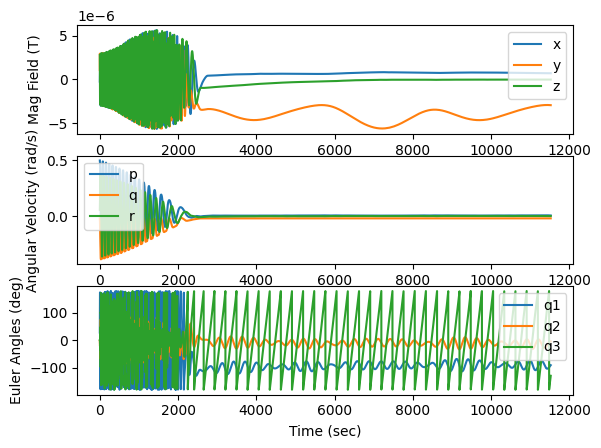

In [77]:

fig, (ax1, ax2,ax3) = plt.subplots(3)

ax1.plot(BBx_list, label = 'x')
ax1.plot(BBy_list, label = 'y')
ax1.plot(BBz_list, label = 'z')
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Mag Field (T)')
ax1.legend()

ax2.plot(pF, label = 'p')
ax2.plot(qF, label = 'q')
ax2.plot(rF, label = 'r')
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Angular Velocity (rad/s)')
ax2.legend()

q1 = stateout[:,7]
q2 = stateout[:,8]
q3 = stateout[:,9]


ptp = Quaternions2EulerAngles(stateout[:,6:10])

ax3.plot(ptp[:,0]*180/np.pi, label = 'q1')
ax3.plot(ptp[:,1]*180/np.pi, label = 'q2')
ax3.plot(ptp[:,2]*180/np.pi, label = 'q3')
ax3.set_xlabel('Time (sec)')
ax3.set_ylabel('Euler Angles (deg)')
ax3.legend()

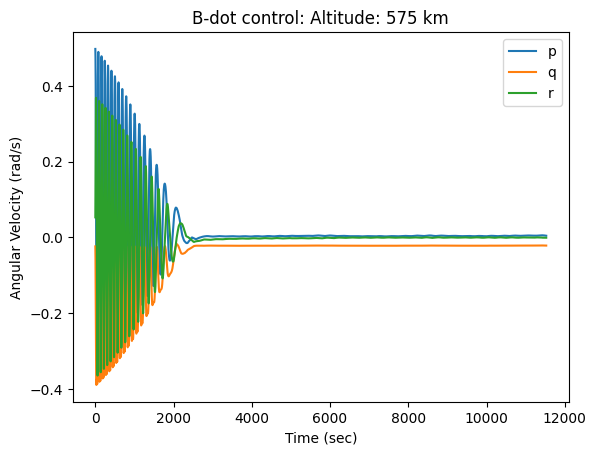

In [78]:
fig, (ax1) = plt.subplots(1)
ax1.plot(pF, label = 'p')
ax1.plot(qF, label = 'q')
ax1.plot(rF, label = 'r')
ax1.legend()
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Angular Velocity (rad/s)')
ax1.set_title('B-dot control: Altitude: 575 km')
plt.show()

Altitude = 700 km

In [54]:
altitude = 700*1000 #meters
x0 = R + altitude
y0 = 0
z0 = 0
xdot0 = 0
inclination = 51.6*np.pi/180
semi_major = LA.norm([x0,y0,z0])
vcircular = np.sqrt(mu/semi_major)
ydot0 = vcircular*np.cos(inclination)
zdot0 = vcircular*np.sin(inclination)
#Intitial Conditions for Attitude and Angular Velocity
phi0 = 0
theta0 = 0
psi0 = 0
ptp0 = np.array([phi0,theta0,psi0])
q0123_0 = EulerAngles2Quaternions(ptp0)
p0 = 0.5
q0 = -0.02
r0 = 0.03
initial_state_f = np.array([x0,y0,z0,xdot0,ydot0,zdot0,q0123_0[0],q0123_0[1],q0123_0[2],q0123_0[3],p0,q0,r0])
print('init_state',initial_state_f.shape)
Bx_list = []
By_list = []
Bz_list = []
BBx_list = []
BBy_list = []
BBz_list = []
BB_meas_x_list = []
BB_meas_y_list = []
BB_meas_z_list = []
p_meas_list = []
q_meas_list = []
r_meas_list = []
nextSensorUpdate = 1
lastSensorUpdate = 0.0
fsensor=1
period = 2*np.pi/(np.sqrt(mu))*semi_major**(3/2)
print('period',period)
number_of_orbits = 2
tfinal = period*number_of_orbits
timestep = 1
tout = np.arange(tfinal)
tout = np.arange(0,tfinal,timestep,dtype = int)
time = tout
print('tout',tout)
state = initial_state_f
lastPrint = 0
next = 1
stateout = np.zeros((len(tout),13))
print('stateout',stateout.shape)
BB_f_prev = np.zeros((3,1))
for idx in range(len(tout)):
    #print(idx)
    if idx > lastPrint:
        print(['Time = ',idx,' out of ',tfinal])
        lastPrint = lastPrint + next
    k1 = Satellite(idx, state)
    k2 = Satellite(idx + timestep / 2, state + k1 * timestep / 2)
    k3 = Satellite(idx + timestep / 2, state + k2 * timestep / 2)
    k4 = Satellite(idx + timestep, state + k3 * timestep)
    k = (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    state = state + k * timestep
    stateout[idx] = state
    Bx_list.append(Bx)
    By_list.append(By)
    Bz_list.append(Bz)
    BBx_list.append(BB_f[0])
    BBy_list.append(BB_f[1])
    BBz_list.append(BB_f[2])
    x = stateout[:,0]/1000
y = stateout[:,1]/1000
z = stateout[:,2]/1000

pF = stateout[:,10]
qF = stateout[:,11]
rF = stateout[:,12]

#ax.plot3D(x, y, z, 'green', linewidth=3)
# Create a grid of points on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for a sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

init_state (13,)
period 5919.408444829672
tout [    0     1     2 ... 11836 11837 11838]
stateout (11839, 13)
['Time = ', 1, ' out of ', 11838.816889659343]
['Time = ', 2, ' out of ', 11838.816889659343]
['Time = ', 3, ' out of ', 11838.816889659343]
['Time = ', 4, ' out of ', 11838.816889659343]
['Time = ', 5, ' out of ', 11838.816889659343]
['Time = ', 6, ' out of ', 11838.816889659343]
['Time = ', 7, ' out of ', 11838.816889659343]
['Time = ', 8, ' out of ', 11838.816889659343]
['Time = ', 9, ' out of ', 11838.816889659343]
['Time = ', 10, ' out of ', 11838.816889659343]
['Time = ', 11, ' out of ', 11838.816889659343]
['Time = ', 12, ' out of ', 11838.816889659343]
['Time = ', 13, ' out of ', 11838.816889659343]
['Time = ', 14, ' out of ', 11838.816889659343]
['Time = ', 15, ' out of ', 11838.816889659343]
['Time = ', 16, ' out of ', 11838.816889659343]
['Time = ', 17, ' out of ', 11838.816889659343]
['Time = ', 18, ' out of ', 11838.816889659343]
['Time = ', 19, ' out of ', 11838.8

<ipython-input-40-98db274b5c6a>:8: RuntimeWarning: invalid value encountered in arcsin
  euler[1] = np.arcsin(2 * (q_0 * q_2 - q_3 * q_1))  # theta


Streaming output truncated to the last 5000 lines.
['Time = ', 6839, ' out of ', 11838.816889659343]
['Time = ', 6840, ' out of ', 11838.816889659343]
['Time = ', 6841, ' out of ', 11838.816889659343]
['Time = ', 6842, ' out of ', 11838.816889659343]
['Time = ', 6843, ' out of ', 11838.816889659343]
['Time = ', 6844, ' out of ', 11838.816889659343]
['Time = ', 6845, ' out of ', 11838.816889659343]
['Time = ', 6846, ' out of ', 11838.816889659343]
['Time = ', 6847, ' out of ', 11838.816889659343]
['Time = ', 6848, ' out of ', 11838.816889659343]
['Time = ', 6849, ' out of ', 11838.816889659343]
['Time = ', 6850, ' out of ', 11838.816889659343]
['Time = ', 6851, ' out of ', 11838.816889659343]
['Time = ', 6852, ' out of ', 11838.816889659343]
['Time = ', 6853, ' out of ', 11838.816889659343]
['Time = ', 6854, ' out of ', 11838.816889659343]
['Time = ', 6855, ' out of ', 11838.816889659343]
['Time = ', 6856, ' out of ', 11838.816889659343]
['Time = ', 6857, ' out of ', 11838.816889659343]

In [55]:
x = stateout[:,0]/1000
y = stateout[:,1]/1000
z = stateout[:,2]/1000

pF = stateout[:,10]
qF = stateout[:,11]
rF = stateout[:,12]

#ax.plot3D(x, y, z, 'green', linewidth=3)
# Create a grid of points on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for a sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

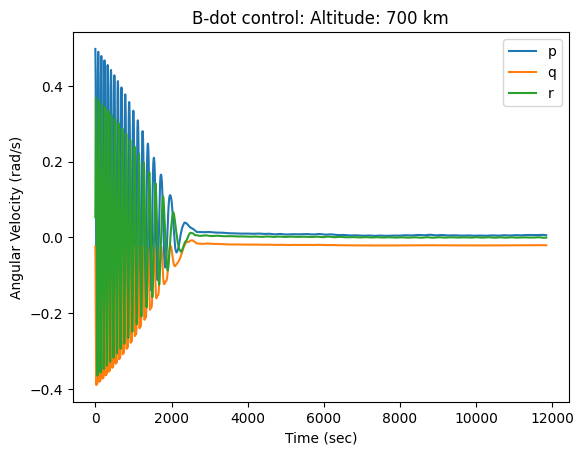

In [56]:
fig, (ax1) = plt.subplots(1)
ax1.plot(pF, label = 'p')
ax1.plot(qF, label = 'q')
ax1.plot(rF, label = 'r')
ax1.legend()
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Angular Velocity (rad/s)')
ax1.set_title('B-dot control: Altitude: 700 km')
plt.show()

Altitude: 450 km

In [57]:
altitude = 450*1000 #meters
x0 = R + altitude
y0 = 0
z0 = 0
xdot0 = 0
inclination = 51.6*np.pi/180
semi_major = LA.norm([x0,y0,z0])
vcircular = np.sqrt(mu/semi_major)
ydot0 = vcircular*np.cos(inclination)
zdot0 = vcircular*np.sin(inclination)
#Intitial Conditions for Attitude and Angular Velocity
phi0 = 0
theta0 = 0
psi0 = 0
ptp0 = np.array([phi0,theta0,psi0])
q0123_0 = EulerAngles2Quaternions(ptp0)
p0 = 0.5
q0 = -0.02
r0 = 0.03
initial_state_f = np.array([x0,y0,z0,xdot0,ydot0,zdot0,q0123_0[0],q0123_0[1],q0123_0[2],q0123_0[3],p0,q0,r0])
print('init_state',initial_state_f.shape)
Bx_list = []
By_list = []
Bz_list = []
BBx_list = []
BBy_list = []
BBz_list = []
BB_meas_x_list = []
BB_meas_y_list = []
BB_meas_z_list = []
p_meas_list = []
q_meas_list = []
r_meas_list = []
nextSensorUpdate = 1
lastSensorUpdate = 0.0
fsensor=1
period = 2*np.pi/(np.sqrt(mu))*semi_major**(3/2)
print('period',period)
number_of_orbits = 2
tfinal = period*number_of_orbits
timestep = 1
tout = np.arange(tfinal)
tout = np.arange(0,tfinal,timestep,dtype = int)
time = tout
print('tout',tout)
state = initial_state_f
lastPrint = 0
next = 1
stateout = np.zeros((len(tout),13))
print('stateout',stateout.shape)
BB_f_prev = np.zeros((3,1))
for idx in range(len(tout)):
    #print(idx)
    if idx > lastPrint:
        print(['Time = ',idx,' out of ',tfinal])
        lastPrint = lastPrint + next
    k1 = Satellite(idx, state)
    k2 = Satellite(idx + timestep / 2, state + k1 * timestep / 2)
    k3 = Satellite(idx + timestep / 2, state + k2 * timestep / 2)
    k4 = Satellite(idx + timestep, state + k3 * timestep)
    k = (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    state = state + k * timestep
    stateout[idx] = state
    Bx_list.append(Bx)
    By_list.append(By)
    Bz_list.append(Bz)
    BBx_list.append(BB_f[0])
    BBy_list.append(BB_f[1])
    BBz_list.append(BB_f[2])
    x = stateout[:,0]/1000
y = stateout[:,1]/1000
z = stateout[:,2]/1000

pF = stateout[:,10]
qF = stateout[:,11]
rF = stateout[:,12]

#ax.plot3D(x, y, z, 'green', linewidth=3)
# Create a grid of points on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for a sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

init_state (13,)
period 5608.272742664585
tout [    0     1     2 ... 11214 11215 11216]
stateout (11217, 13)
['Time = ', 1, ' out of ', 11216.54548532917]
['Time = ', 2, ' out of ', 11216.54548532917]
['Time = ', 3, ' out of ', 11216.54548532917]
['Time = ', 4, ' out of ', 11216.54548532917]
['Time = ', 5, ' out of ', 11216.54548532917]
['Time = ', 6, ' out of ', 11216.54548532917]
['Time = ', 7, ' out of ', 11216.54548532917]
['Time = ', 8, ' out of ', 11216.54548532917]
['Time = ', 9, ' out of ', 11216.54548532917]
['Time = ', 10, ' out of ', 11216.54548532917]
['Time = ', 11, ' out of ', 11216.54548532917]
['Time = ', 12, ' out of ', 11216.54548532917]
['Time = ', 13, ' out of ', 11216.54548532917]
['Time = ', 14, ' out of ', 11216.54548532917]
['Time = ', 15, ' out of ', 11216.54548532917]
['Time = ', 16, ' out of ', 11216.54548532917]
['Time = ', 17, ' out of ', 11216.54548532917]
['Time = ', 18, ' out of ', 11216.54548532917]
['Time = ', 19, ' out of ', 11216.54548532917]
['Time

<ipython-input-40-98db274b5c6a>:8: RuntimeWarning: invalid value encountered in arcsin
  euler[1] = np.arcsin(2 * (q_0 * q_2 - q_3 * q_1))  # theta


Streaming output truncated to the last 5000 lines.
['Time = ', 6217, ' out of ', 11216.54548532917]
['Time = ', 6218, ' out of ', 11216.54548532917]
['Time = ', 6219, ' out of ', 11216.54548532917]
['Time = ', 6220, ' out of ', 11216.54548532917]
['Time = ', 6221, ' out of ', 11216.54548532917]
['Time = ', 6222, ' out of ', 11216.54548532917]
['Time = ', 6223, ' out of ', 11216.54548532917]
['Time = ', 6224, ' out of ', 11216.54548532917]
['Time = ', 6225, ' out of ', 11216.54548532917]
['Time = ', 6226, ' out of ', 11216.54548532917]
['Time = ', 6227, ' out of ', 11216.54548532917]
['Time = ', 6228, ' out of ', 11216.54548532917]
['Time = ', 6229, ' out of ', 11216.54548532917]
['Time = ', 6230, ' out of ', 11216.54548532917]
['Time = ', 6231, ' out of ', 11216.54548532917]
['Time = ', 6232, ' out of ', 11216.54548532917]
['Time = ', 6233, ' out of ', 11216.54548532917]
['Time = ', 6234, ' out of ', 11216.54548532917]
['Time = ', 6235, ' out of ', 11216.54548532917]
['Time = ', 6236, 

In [58]:
x = stateout[:,0]/1000
y = stateout[:,1]/1000
z = stateout[:,2]/1000

pF = stateout[:,10]
qF = stateout[:,11]
rF = stateout[:,12]

#ax.plot3D(x, y, z, 'green', linewidth=3)
# Create a grid of points on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Parametric equations for a sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

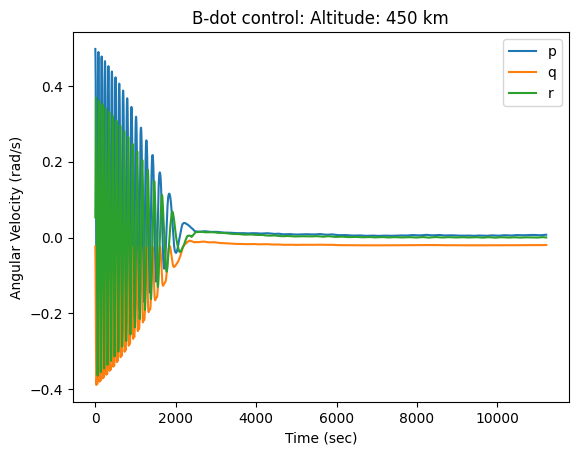

In [59]:
fig, (ax1) = plt.subplots(1)
ax1.plot(pF, label = 'p')
ax1.plot(qF, label = 'q')
ax1.plot(rF, label = 'r')
ax1.legend()
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Angular Velocity (rad/s)')
ax1.set_title('B-dot control: Altitude: 450 km')
plt.show()